In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


# matplotlib.use('Agg')
import os
from os import walk
import cv2



from datetime import datetime
from pytz import timezone


import cntk.tests.test_utils
import cntk as C
from cntk.layers import Convolution, MaxPooling, Dense
from cntk.initializer import glorot_uniform
from cntk.ops import relu, sigmoid, input_variable
from cntk.learners import learning_rate_schedule, UnitType
from cntk.device import try_set_default_device, gpu, all_devices
from cntk.ops.functions import load_model
global result_path 
global report_root 
global report_img_path 
global img_predict_dir_path
global img_blending_dir_path 
global img_test_dir_path 


In [2]:
def get_window( img, y, x, size = 31 ):
    temp = (size - 1) // 2
    x1 = x - temp
    x2 = x + 1 + temp
    y1 = y - temp
    y2 = y + 1 + temp
    window = img[ y1:y2, x1:x2, :]
    return window

In [3]:
def read_color_img(path):
    bgr = cv2.imread( path, cv2.IMREAD_COLOR )
    b, g, r = cv2.split( bgr )
    img = cv2.merge( [r, g, b] )
    return img

In [4]:
def to_bgr(rgb):
    r, g, b = cv2.split( rgb )
    bgr = cv2.merge( [b, g, r] )
    return bgr

In [5]:
def read_gray_img(path):
    img = cv2.imread( path, cv2.IMREAD_GRAYSCALE)
    return img

In [6]:
def get_largest_component (image):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    max_label = 1
    if len(sizes) >= 2:
        max_size = sizes[1]
    else :
        max_size = sizes[0]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

In [7]:
def union( img1, img2):
    h, w = img1.shape
    img = np.zeros( shape = (h,w)  , dtype = np.uint8)
    for row in range(h):
        for col in range(w):
            v1 = img1[row, col]
            v2 = img2[row, col]
            if v1 == 255 or v2 == 255:
                img[row, col] = 255
    return img

In [8]:
def intersection( img1, img2):
    h, w = img1.shape
    img = np.zeros( shape = (h,w)  , dtype = np.uint8)
    for row in range(h):
        for col in range(w):
            v1 = img1[row, col]
            v2 = img2[ row, col]
            if v1 == 255 and v2 == 255:
                img[row, col] = 255
    return img

In [44]:
def get_IoU( img1, img2):
    union_img = union(img1, img2)
    intersection_img = intersection(img1, img2)
    sum_union = 0
    sum_intersection = 0
    h, w = union_img.shape
    for row in range(h):
        for col in range(w):
            v1 = union_img[row, col]
            v2 = intersection_img[row, col]
            if v1 == 255:
                sum_union += 1
            if v2 == 255:
                sum_intersection += 1
    return sum_intersection / sum_union

def get_dice( img1, img2):
#     union_img = union(img1, img2)
#     intersection_img = intersection(img1, img2)
    sum_union = 0
    sum_intersection = 0
    h, w = img1.shape
    count_1, count_2 = 0, 0
    for row in range(h):
        for col in range(w):
            if img1[row, col] == 255:
                count_1 += 1 
            if img2[row, col] == 255:
                count_2 += 1
            if img1[row, col] == 255 and img2[row, col] == 255: 
                sum_intersection += 1
    return (2*sum_intersection) / (count_1 + count_2)

In [45]:
def show_img(img, title=None, mode=None):
    plt.imshow(img, cmap=mode)
    plt.title(title)
    plt.show()

In [46]:
def alpha_blending( fg, bg, alpha = 0.3 ):
    new_img = np.array(bg)
    rows, cols = fg.shape
    for row in range(rows):
        for col in range(cols):
            if fg[row, col] == 255:                
                value = ( (1-alpha) * 255 ) +  ( alpha * bg[row, col, 2] )
                new_img[row, col, 2] = int(value)
                new_img[row, col, 0] = bg[row, col, 0]
                new_img[row, col, 1] = bg[row, col, 1]
    return new_img

In [12]:
def predict( img_color, model, stride=2):
    num_pixel = 0
    height, width, chanel = img_color.shape
    img_predict = np.zeros( shape = (height, width)  , dtype = np.uint8)
    print("shape => {:d},{:d}".format(height, width))
    
    white = np.asarray([255])
    
    for row in range(15, height - 15, stride):
        data = list()
        for col in range(15, width - 15, stride):
            num_pixel += 1
            w = get_window( img_color , row, col, 31 )
            tmp_data = np.asarray(w, dtype=np.float32)
            tmp_data = np.reshape( tmp_data, (3,31,31))
            data.append(tmp_data)
        
        data_array = np.array(data)
        predictions = model.eval(data_array)
        
        for index in range(len(data)):
            col = 15 + (stride * index)
            p = predictions[index]
            top_class = np.argmax(p)
            if top_class == 1:
                img_predict[row, col] = white
            elif top_class == 2 :
                img_predict[row, col] = white
    print("num pixel => {:d}".format(num_pixel))
    return img_predict

In [13]:
def segment( color_path, model,img_predict_dir_path ):
    img_color = read_color_img( color_path )
    img_predict = predict( img_color, model )
    
    cv2.imwrite('%s/%s_predict1.png' % ( img_predict_dir_path, get_name_img_color(color_path)), img_predict )
    img_predict = cv2.dilate( img_predict, np.ones( (5,5) , np.uint8), iterations=1)
    img_predict = cv2.erode( img_predict, np.ones( (5,5) , np.uint8), iterations=1)
    img_predict = cv2.dilate( img_predict, np.ones( (3,3) , np.uint8), iterations=1)
    
    img_predict = get_largest_component(img_predict)
    img_blending = alpha_blending( fg=img_predict, bg=img_color )
    
    return img_color, img_predict 

In [14]:
def test_predict( img_predict, img_gray):
    num_pixel_all = 0 
    num_pixel_tp = 0
    num_pixel_fp = 0
    num_pixel_tn = 0 
    num_pixel_fn = 0
#     print(img_predict.shape)
    height, width = img_predict.shape
    test_img = np.zeros( shape = (height, width, 3)  , dtype = np.uint8)
    for row in range(height):
        for col in range(width):
            num_pixel_all += 1
            red = [ 255, 0, 0]
            green = [ 0, 255, 0]
            yellow = [ 255, 255, 0]
            # wrong = red, right = green
            if img_predict[row, col] and img_gray[row, col] == 255:
                num_pixel_tp += 1
                test_img[row, col] = green                
            elif img_predict[row, col] == 255 and img_gray[row, col] == 0:
                num_pixel_fp += 1
                test_img[row, col] = yellow
            elif img_predict[row, col] == 0 and img_gray[row, col] == 255:
                num_pixel_tn += 1
                test_img[row, col] = red
            else :
                num_pixel_fn += 1
    return test_img, num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn

In [15]:
def get_name_img_color(path):
    last_slash_index = path.rfind('/')
    last_dot_index = path.rfind('.')
    name = path[ last_slash_index + 1: last_dot_index]
    return name

In [16]:
def get_name_img_gray(path):
    last_slash_index = path.rfind('/')
    last_under_index = path.rfind('_')
    name = path[ last_slash_index + 1: last_under_index]
    return name

In [17]:
def get_all_file_paths(root):
    paths = list()
    for _, _, files in os.walk(root):
        for file in files:
            paths.append( os.path.join( root, file ) )
    paths.sort()
    return paths

In [34]:
def process(color_path, gray_path,report_root,model,img_predict_dir_path,img_blending_dir_path,img_test_dir_path,report_img_path, gray_dir_path):
    name = get_name_img_color(color_path)
    
    write_log('PREDICT... %s' % name,report_root)
    
    img_color, img_predict = predict_image(color_path, model, img_predict_dir_path)#predict_image(color_path, model)
    img_gray = read_gray_img(gray_path)
    
    img_test, num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn = test_predict( img_predict, img_gray )
    
    img_alpha_blening = alpha_blending( img_predict, img_color )
    
    iou_value = get_dice( img_gray, img_predict)
    
    write_log(' , Dice = %s' % iou_value,report_root )
    
    
    cv2.imwrite('%s/%s_predict2.png' % ( img_predict_dir_path, name) , img_predict )
    
    cv2.imwrite('%s/%s_blending.png' % ( img_blending_dir_path, name) , to_bgr(img_alpha_blening ) )
    
    cv2.imwrite('%s/%s_compare.png' % ( img_test_dir_path, name) , to_bgr(img_test ) )
    plt.close()
    
    plt.figure()
    
    plt.subplot(221)
    plt.imshow(img_color)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(222)
    plt.imshow(img_predict, cmap='gray')
    plt.title("Predicted")
    plt.axis('off')
    
    plt.subplot(223)
    plt.imshow(img_alpha_blening)
    plt.title("Blending")
    plt.axis('off')   
    
    plt.subplot(224)
    plt.imshow(img_test)
    plt.title("%s" % iou_value)
    plt.axis('off')
    

    fig_name = '%s/%s_report.png' % ( report_img_path, name )
    write_log('Saving... %s' % fig_name,report_root)
    plt.savefig( fig_name )
    plt.show()
    
    return iou_value, num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn

In [35]:
def check_paths( img_paths ):
    num_img = len(img_paths)
    for image in img_paths:
        path_color = "../testing_data/images/" + type_folder + image[:-4] + ".png"
        path_gray = gray_dir_path + image[:-4] + "_gray.png"
        
        color_name = get_name_img_color(path_color)
        gray_name = get_name_img_gray(path_gray)
        if not color_name == gray_name:
            raise Exception('%s not match %s' % ( color_name, gray_name))
            return False
    return True

In [36]:
def prepare_folder(result_path, report_root, report_img_path, img_predict_dir_path, img_blending_dir_path,img_test_dir_path):    
    if not os.path.exists(result_path):
        os.mkdir(result_path)
    if not os.path.exists(report_root):
        os.mkdir(report_root)
    if not os.path.exists(report_img_path):
        os.mkdir(report_img_path)
    if not os.path.exists(img_predict_dir_path):
        os.mkdir(img_predict_dir_path)
    if not os.path.exists(img_blending_dir_path):
        os.mkdir(img_blending_dir_path)
    if not os.path.exists(img_test_dir_path):
        os.mkdir(img_test_dir_path)

In [37]:
def write_log(line, report_root, mode='a'):
    print(line)
    with open('%s/log.txt' % report_root, mode) as file:
        file.write( line + '\n' )

In [38]:
def process2(result_path, report_root, report_img_path, img_predict_dir_path, img_blending_dir_path,img_test_dir_path, model, gray_dir_path):
    prepare_folder(result_path, report_root, report_img_path, img_predict_dir_path, img_blending_dir_path,img_test_dir_path)
    
    s = datetime.now(timezone('Asia/Bangkok')).strftime('date: %Y-%m-%d ,time: %H:%M:%S')
    write_log("START : %s"%s, report_root,'w')

    img_paths = get_image_file(color_dir_path)

    if not check_paths( img_paths ):
        raise Exception('List not match each other. Please check name of image.')

#     num_test = len( img_paths )
    iou_list = list()
    
    num_pixel_all = 0
    num_pixel_tp = 0
    num_pixel_fp = 0
    num_pixel_tn = 0
    num_pixel_fn = 0

    for image in img_paths:
        
        color_path = color_dir_path + image
        gray_path  = gray_dir_path + image[:-4] + "_gray.png"
        iou_value, pixel_all, pixel_tp, pixel_fp, pixel_tn, pixel_fn = process(color_path, gray_path, report_root,model, img_predict_dir_path, img_blending_dir_path, img_test_dir_path, report_img_path, gray_dir_path)
        iou_list.append(iou_value)
        num_pixel_all += pixel_all 
        num_pixel_tp += pixel_tp
        num_pixel_fp += pixel_fp
        num_pixel_tn += pixel_tn
        num_pixel_fn += pixel_fn
    
  
    iou_sum = sum(iou_list)
    iou_avg = iou_sum / len(iou_list)
    iou_min = min(iou_list)
    line = 'SEGMENTATION REPORT :: dice_avg %s, dice_min %s' % ( iou_avg, iou_min)

    e = datetime.now(timezone('Asia/Bangkok')).strftime('date: %Y-%m-%d ,time: %H:%M:%S')

    write_log(line, report_root)
    write_log(e, report_root)
    return num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn

In [23]:
def confusion_matrix(num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn) :
    precision = num_pixel_tp/(num_pixel_tp + num_pixel_fp)*100
    recall = num_pixel_tp/(num_pixel_tp + num_pixel_tn)*100
    f_measure = (2*precision*recall) / (precision + recall)
    accuracy = (num_pixel_tp + num_pixel_fn) / num_pixel_all
    print("\twound\tnot wound")
    print("    wound\t{:d}\t{:d}".format(num_pixel_tp, num_pixel_fp))
    print("not wound\t{:d}\t{:d}".format(num_pixel_tn, num_pixel_fn))
    print("precision => {:.2f}".format(precision))
    print("recall => {:.2f}".format(recall))
    print("f-measure => {:.2f}".format(f_measure))
    print("accuracy => {:.2f}".format(accuracy*100))
    print("all sample => {:d}".format(num_pixel_all))

In [24]:
def over_flitting_plot(src) :
    training_errors = np.loadtxt(src + "training_result.txt")
    test_errors = np.loadtxt(src + "test_result.txt")
    
    s_list = sorted({"training": training_errors, "test": test_errors}.items())
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format("accuracy"))

    for label, result in s_list:
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

In [40]:
def segmentation(root_path, model_name, color_dir_path, gray_dir_path):
    
#     over_flitting_plot(root_path + "results/" + model_name[:-6] + "/")
    model_path = root_path + model_name

    model_name = get_name_img_color(model_path)
    result_path = root_path + 'results'
    report_root = root_path + 'results/%s' % model_name
    report_img_path = root_path + 'results/%s/reports' % model_name
    img_predict_dir_path = root_path + 'results/%s/predict/' % model_name
    img_blending_dir_path = root_path + 'results/%s/blending' % model_name
    img_test_dir_path = root_path + 'results/%s/compare/' % model_name


    if os.path.exists(color_dir_path):
        print('Image Dir is %s' % color_dir_path)
    else:
        raise Exception('%s not found.' % color_dir_path)

    if os.path.exists(model_path):
        print('Model is %s' % model_path)
    else:
        raise Exception('%s not found.' % model_path)

    model = load_model(model_path)
    num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn = process2(result_path, report_root, report_img_path, img_predict_dir_path, img_blending_dir_path,img_test_dir_path, model, gray_dir_path)
    confusion_matrix(num_pixel_all, num_pixel_tp, num_pixel_fp, num_pixel_tn, num_pixel_fn)

In [29]:
input_dim_model = (3, 256, 256)
input_dim = 3 * 256 * 256
num_output_classes = 256 * 256

def create_reader_text(path, is_training, input_dim, num_label_classes):   

    labelStream = cntk.io.StreamDef(field='label', shape=num_label_classes, is_sparse=False)
    featureStream = cntk.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
#     coordinateStream = cntk.io.StreamDef(field='coordinate', shape=2, is_sparse=False)
    
#     deserailizer = cntk.io.CBFDeserializer(path, cntk.io.StreamDefs(label = labelStream ,feature = featureStream))
    deserailizer = cntk.io.CTFDeserializer(path, cntk.io.StreamDefs(label = labelStream ,feature = featureStream))      
    return cntk.io.MinibatchSource(deserailizer,
       randomize = False, multithreaded_deserializer=False,max_sweeps = cntk.io.INFINITELY_REPEAT if is_training else 1)


def create_reader_binary(path, is_training, input_dim, num_label_classes):   

    labelStream = cntk.io.StreamDef(field='label', shape=num_label_classes, is_sparse=False)
    featureStream = cntk.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
#     coordinateStream = cntk.io.StreamDef(field='coordinate', shape=2, is_sparse=False)
    
    deserailizer = cntk.io.CBFDeserializer(path, cntk.io.StreamDefs(label = labelStream ,feature = featureStream))
#     deserailizer = cntk.io.CTFDeserializer(path, cntk.io.StreamDefs(label = labelStream ,feature = featureStream))      
    return cntk.io.MinibatchSource(deserailizer,
       randomize = False, multithreaded_deserializer=False,max_sweeps = cntk.io.INFINITELY_REPEAT if is_training else 1)

def load_test(src_file) :
        
    return create_reader_text(src_file, False, input_dim, num_output_classes)

def create_white_image():
    img = np.zeros(shape = (256,256) ,dtype = np.uint8)
    img.fill(255)
    return img

def predict_image(src_file, model, img_predict_dir_path) :
    print(src_file)
    
    samples_train_size = len(open(src_file).readlines())
    print("sample => {:d}".format(samples_train_size))
    reader_test = load_test(src_file)
    
    minibatch_size = 1
    num_samples_per_sweep = samples_train_size
    num_minibatches_to_train = (num_samples_per_sweep ) / minibatch_size
    
    input_map = {'label': reader_test.streams.label, 'input': reader_test.streams.feature} 

#     print(reader_test.streams.label)
#     print(reader_test.streams.feature)


    data_x, data_y = [], []
    for i in range(0, int(num_minibatches_to_train)):

        # Read a mini batch from the training data file
        data = reader_test.next_minibatch(minibatch_size, input_map=input_map) 

        training_data = []
        for k in data.keys() :
            for v in data[k].as_sequences()[0] :
                 training_data.append(v)

        data_x.append(training_data[0])
        data_y.append(training_data[1])



    labels = np.reshape(data_x, (num_samples_per_sweep,1,256,256))
    features = np.reshape(data_y,(num_samples_per_sweep,3,256,256))
    
    pred = prediction_image(features, model)
    img = create_white_image()
    rows, cols = pred[0][0].shape

    for row in range(rows) :
        for col in range(cols) :
            if pred[0,0,row,col] > 0.5:
                img[row,col] = 255
            else :
                img[row,col] = 0

    cv2.imwrite('%s/%s_predict1.png' % ( img_predict_dir_path, get_name_img_color(src_file)), img )
    
    
    return read_color_img('../testing_data/images/' + type_folder + get_name_img_color(src_file)+".png" ), img

def prediction_image(features_image, model) :
    return model.eval(features_image)

    
def create_white_image():
    img = np.zeros(shape = (256,256) ,dtype = np.uint8)
    img.fill(255)
    return img

def get_image_file(src_folder):
    images = []
    for (dirpath, dirnames, filenames) in walk(src_folder):
        images.extend(filenames)
        
    return images

def show_prediction_image(image):
    print(image[0][0].shape)
    
    img = create_white_image()
    rows, cols = image[0][0].shape

    for row in range(rows) :
        for col in range(cols) :
            if image[0,0,row,col] >= 0.5:
                img[row,col] = 255
            else :
                img[row,col] = 0
                
#     plt.imshow(img,'gray')
#     plt.show()

In [31]:
type_folder = "original/"

root_path = '../training_data/model/' + type_folder
color_dir_path = '../testing_data/features/' + type_folder
gray_dir_path = '../testing_data/images/gray/'

Image Dir is ../testing_data/features/original/
Model is ../training_data/model/original/model81.72.model
START : date: 2018-06-16 ,time: 20:56:40
PREDICT... b_12
../testing_data/features/original/b_12.txt
sample => 1
 , Dice = 0.8850828729281768
Saving... ../training_data/model/original/results/model81.72/reports/b_12_report.png


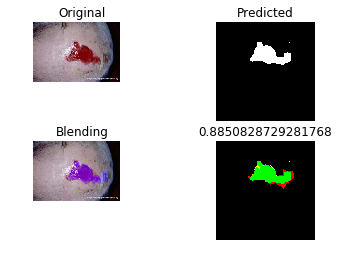

PREDICT... m_03
../testing_data/features/original/m_03.txt
sample => 1
 , Dice = 0.8024937655860349
Saving... ../training_data/model/original/results/model81.72/reports/m_03_report.png


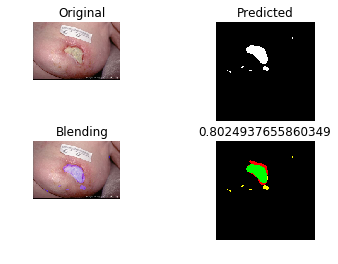

PREDICT... f_50
../testing_data/features/original/f_50.txt
sample => 1
 , Dice = 0.19155941334929663
Saving... ../training_data/model/original/results/model81.72/reports/f_50_report.png


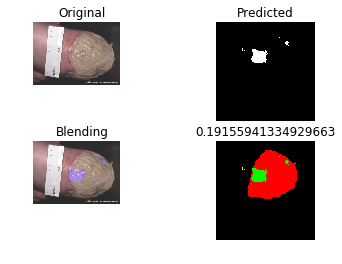

PREDICT... f_35
../testing_data/features/original/f_35.txt
sample => 1
 , Dice = 0.9573393207970811
Saving... ../training_data/model/original/results/model81.72/reports/f_35_report.png


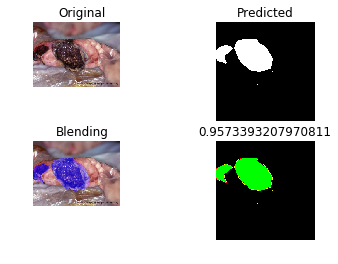

PREDICT... v2_07
../testing_data/features/original/v2_07.txt
sample => 1
 , Dice = 0.9663120567375887
Saving... ../training_data/model/original/results/model81.72/reports/v2_07_report.png


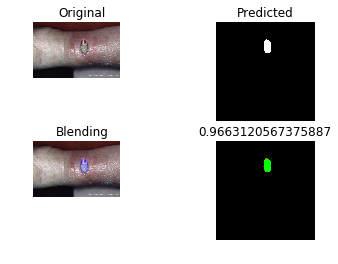

PREDICT... p2_54
../testing_data/features/original/p2_54.txt
sample => 1
 , Dice = 0.953719574905725
Saving... ../training_data/model/original/results/model81.72/reports/p2_54_report.png


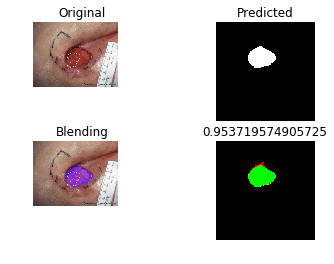

PREDICT... m_47
../testing_data/features/original/m_47.txt
sample => 1
 , Dice = 0.8883485626887329
Saving... ../training_data/model/original/results/model81.72/reports/m_47_report.png


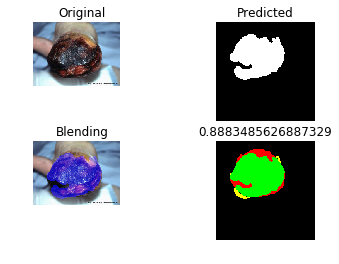

PREDICT... a_04
../testing_data/features/original/a_04.txt
sample => 1
 , Dice = 0.9192399049881235
Saving... ../training_data/model/original/results/model81.72/reports/a_04_report.png


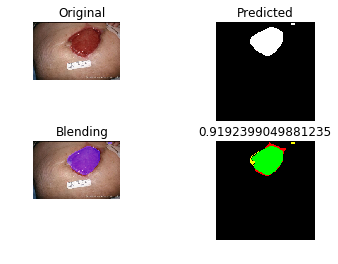

PREDICT... f_41
../testing_data/features/original/f_41.txt
sample => 1
 , Dice = 0.8153273017562533
Saving... ../training_data/model/original/results/model81.72/reports/f_41_report.png


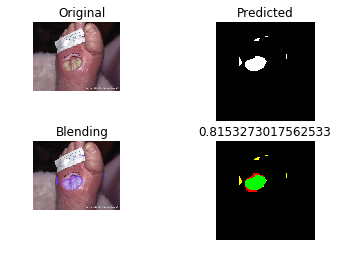

PREDICT... p2_57
../testing_data/features/original/p2_57.txt
sample => 1
 , Dice = 0.9388724035608309
Saving... ../training_data/model/original/results/model81.72/reports/p2_57_report.png


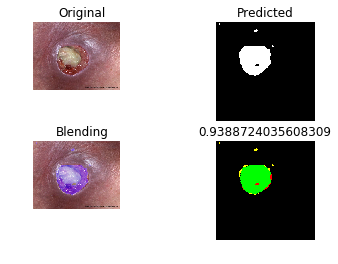

PREDICT... p1_82
../testing_data/features/original/p1_82.txt
sample => 1
 , Dice = 0.9336556540424389
Saving... ../training_data/model/original/results/model81.72/reports/p1_82_report.png


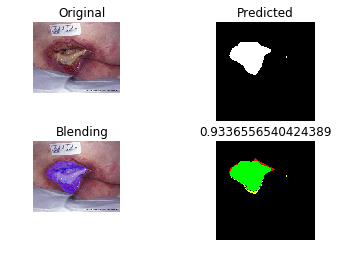

PREDICT... v1_70
../testing_data/features/original/v1_70.txt
sample => 1
 , Dice = 0.94843617920541
Saving... ../training_data/model/original/results/model81.72/reports/v1_70_report.png


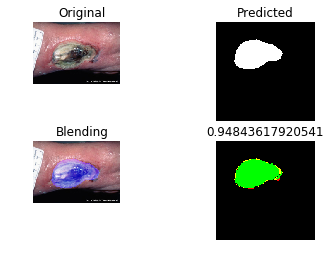

PREDICT... a_05
../testing_data/features/original/a_05.txt
sample => 1
 , Dice = 0.8825065274151436
Saving... ../training_data/model/original/results/model81.72/reports/a_05_report.png


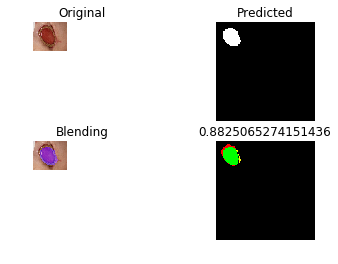

PREDICT... v1_76
../testing_data/features/original/v1_76.txt
sample => 1
 , Dice = 0.6241149741096904
Saving... ../training_data/model/original/results/model81.72/reports/v1_76_report.png


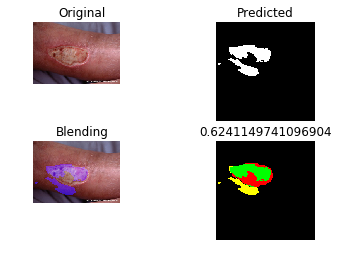

PREDICT... t_25
../testing_data/features/original/t_25.txt
sample => 1
 , Dice = 0.7876526458616011
Saving... ../training_data/model/original/results/model81.72/reports/t_25_report.png


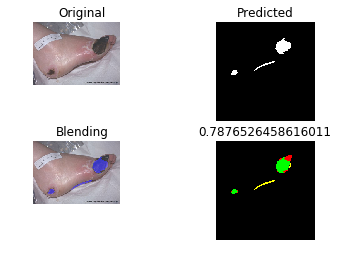

PREDICT... b_11
../testing_data/features/original/b_11.txt
sample => 1
 , Dice = 0.9020172910662824
Saving... ../training_data/model/original/results/model81.72/reports/b_11_report.png


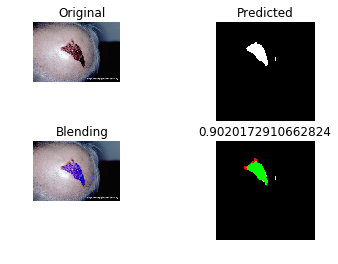

PREDICT... p1_67
../testing_data/features/original/p1_67.txt
sample => 1
 , Dice = 0.8105900577383467
Saving... ../training_data/model/original/results/model81.72/reports/p1_67_report.png


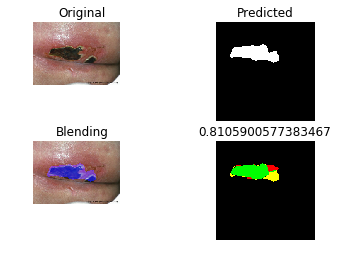

PREDICT... b_05
../testing_data/features/original/b_05.txt
sample => 1
 , Dice = 0.7555046871593634
Saving... ../training_data/model/original/results/model81.72/reports/b_05_report.png


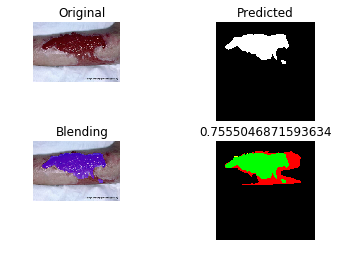

PREDICT... m_43
../testing_data/features/original/m_43.txt
sample => 1
 , Dice = 0.8558741627154361
Saving... ../training_data/model/original/results/model81.72/reports/m_43_report.png


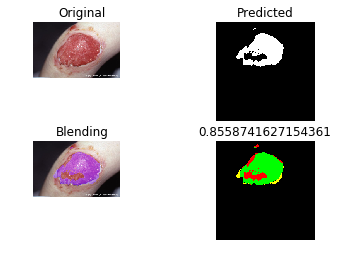

PREDICT... p1_73
../testing_data/features/original/p1_73.txt
sample => 1
 , Dice = 0.8477977234894498
Saving... ../training_data/model/original/results/model81.72/reports/p1_73_report.png


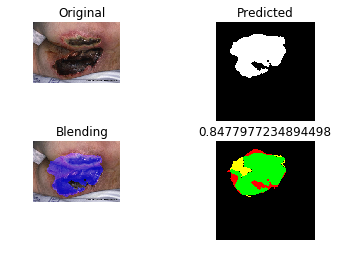

PREDICT... v1_84
../testing_data/features/original/v1_84.txt
sample => 1
 , Dice = 0.7297138377107016
Saving... ../training_data/model/original/results/model81.72/reports/v1_84_report.png


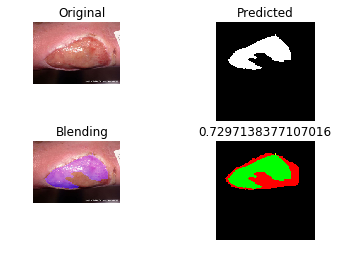

PREDICT... b_20
../testing_data/features/original/b_20.txt
sample => 1
 , Dice = 0.03440525587828493
Saving... ../training_data/model/original/results/model81.72/reports/b_20_report.png


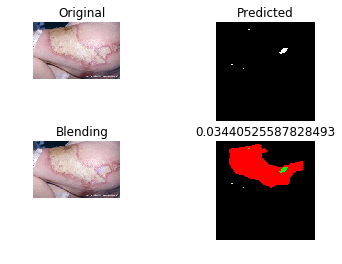

PREDICT... v1_32
../testing_data/features/original/v1_32.txt
sample => 1
 , Dice = 0.9466371027346637
Saving... ../training_data/model/original/results/model81.72/reports/v1_32_report.png


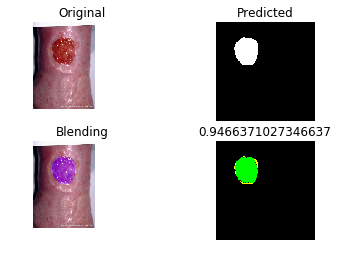

PREDICT... m_25
../testing_data/features/original/m_25.txt
sample => 1
 , Dice = 0.7900422733677783
Saving... ../training_data/model/original/results/model81.72/reports/m_25_report.png


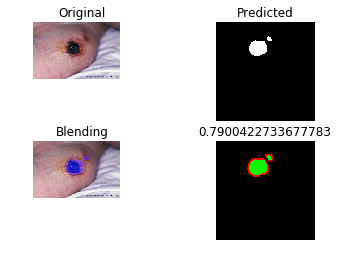

PREDICT... p1_81
../testing_data/features/original/p1_81.txt
sample => 1
 , Dice = 0.6995779318661441
Saving... ../training_data/model/original/results/model81.72/reports/p1_81_report.png


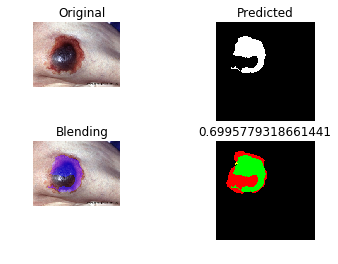

PREDICT... p1_72
../testing_data/features/original/p1_72.txt
sample => 1
 , Dice = 0.8783505154639175
Saving... ../training_data/model/original/results/model81.72/reports/p1_72_report.png


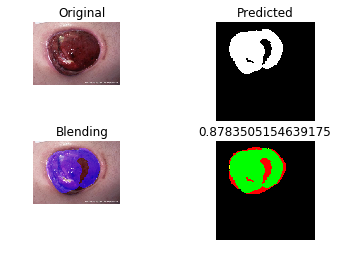

PREDICT... f_18
../testing_data/features/original/f_18.txt
sample => 1
 , Dice = 0.7014925373134329
Saving... ../training_data/model/original/results/model81.72/reports/f_18_report.png


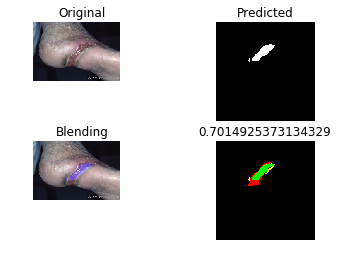

SEGMENTATION REPORT :: dice_avg 0.7943209086828124, dice_min 0.03440525587828493
date: 2018-06-16 ,time: 20:57:11
	wound	not wound
    wound	110791	7714
not wound	52014	1598953
precision => 93.49
recall => 68.05
f-measure => 78.77
accuracy => 96.62
all sample => 1769472


In [47]:
model_name = 'model81.72.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

test original

training 30 epoch

In [ ]:
#k-fold => 1
model_name = 'model40.83.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model35.93.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model36.73.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model41.58.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model35.26.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

training 100 epoch 

Image Dir is ../testing_data/features/original/
Model is ../training_data/model/original/model63.92.model
START : date: 2018-06-11 ,time: 13:16:03
PREDICT... b_12
../testing_data/features/original/b_12.txt
sample => 1
 , IoU = 0.6793268137366386
Saving... ../training_data/model/original/results/model63.92/reports/b_12_report.png


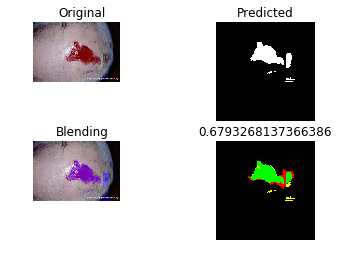

PREDICT... m_03
../testing_data/features/original/m_03.txt
sample => 1
 , IoU = 0.05460434983803795
Saving... ../training_data/model/original/results/model63.92/reports/m_03_report.png


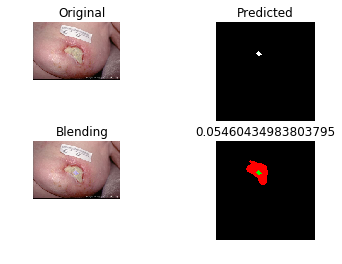

PREDICT... f_50
../testing_data/features/original/f_50.txt
sample => 1
 , IoU = 0.020727966171959208
Saving... ../training_data/model/original/results/model63.92/reports/f_50_report.png


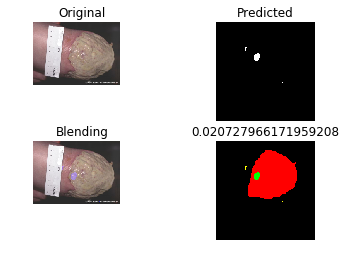

PREDICT... f_35
../testing_data/features/original/f_35.txt
sample => 1
 , IoU = 0.6222598750397119
Saving... ../training_data/model/original/results/model63.92/reports/f_35_report.png


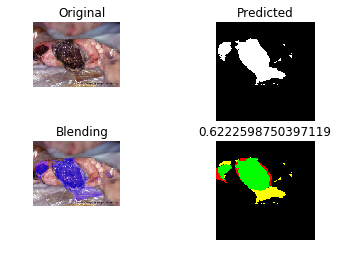

PREDICT... v2_07
../testing_data/features/original/v2_07.txt
sample => 1
 , IoU = 0.8641765704584041
Saving... ../training_data/model/original/results/model63.92/reports/v2_07_report.png


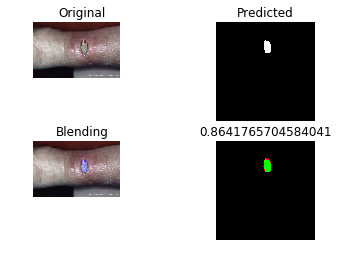

PREDICT... p2_54
../testing_data/features/original/p2_54.txt
sample => 1
 , IoU = 0.8622908622908623
Saving... ../training_data/model/original/results/model63.92/reports/p2_54_report.png


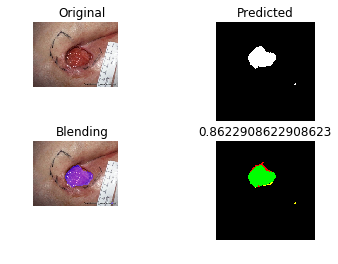

PREDICT... m_47
../testing_data/features/original/m_47.txt
sample => 1
 , IoU = 0.8495645863570392
Saving... ../training_data/model/original/results/model63.92/reports/m_47_report.png


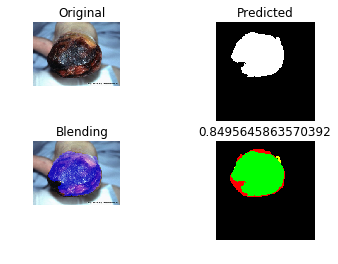

PREDICT... a_04
../testing_data/features/original/a_04.txt
sample => 1
 , IoU = 0.7306967984934086
Saving... ../training_data/model/original/results/model63.92/reports/a_04_report.png


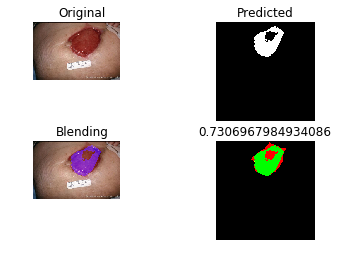

PREDICT... f_41
../testing_data/features/original/f_41.txt
sample => 1
 , IoU = 0.4409333981526495
Saving... ../training_data/model/original/results/model63.92/reports/f_41_report.png


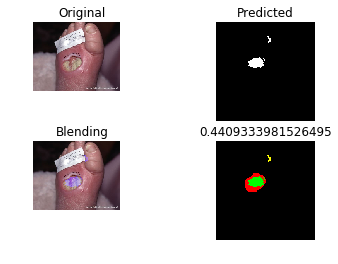

PREDICT... p2_57
../testing_data/features/original/p2_57.txt
sample => 1
 , IoU = 0.9427012278308322
Saving... ../training_data/model/original/results/model63.92/reports/p2_57_report.png


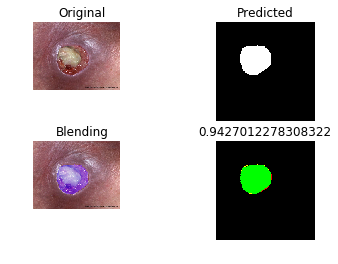

PREDICT... p1_82
../testing_data/features/original/p1_82.txt
sample => 1
 , IoU = 0.7459266802443992
Saving... ../training_data/model/original/results/model63.92/reports/p1_82_report.png


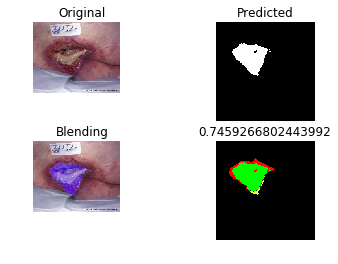

PREDICT... v1_70
../testing_data/features/original/v1_70.txt
sample => 1
 , IoU = 0.8557677846292676
Saving... ../training_data/model/original/results/model63.92/reports/v1_70_report.png


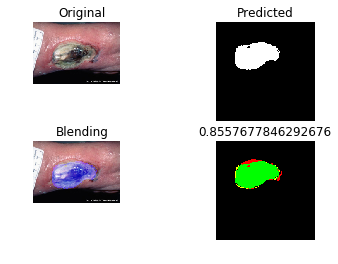

PREDICT... a_05
../testing_data/features/original/a_05.txt
sample => 1
 , IoU = 0.8614270941054809
Saving... ../training_data/model/original/results/model63.92/reports/a_05_report.png


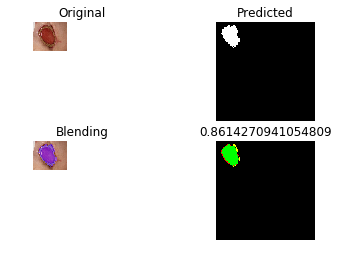

PREDICT... v1_76
../testing_data/features/original/v1_76.txt
sample => 1
 , IoU = 0.004384362440628425
Saving... ../training_data/model/original/results/model63.92/reports/v1_76_report.png


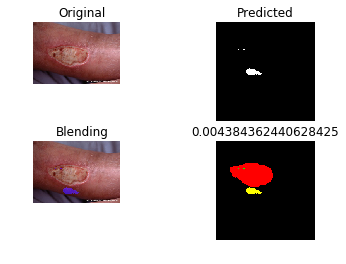

PREDICT... t_25
../testing_data/features/original/t_25.txt
sample => 1
 , IoU = 0.7495373226403454
Saving... ../training_data/model/original/results/model63.92/reports/t_25_report.png


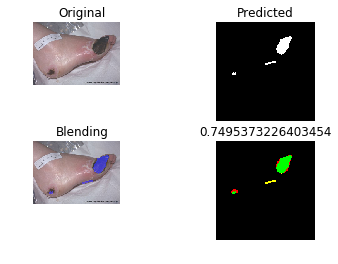

PREDICT... b_11
../testing_data/features/original/b_11.txt
sample => 1
 , IoU = 0.5718942412169504
Saving... ../training_data/model/original/results/model63.92/reports/b_11_report.png


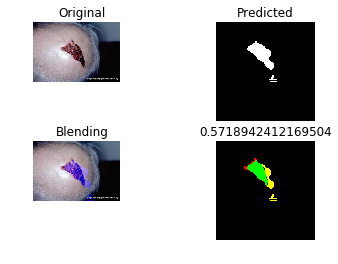

PREDICT... p1_67
../testing_data/features/original/p1_67.txt
sample => 1
 , IoU = 0.5485309548793285
Saving... ../training_data/model/original/results/model63.92/reports/p1_67_report.png


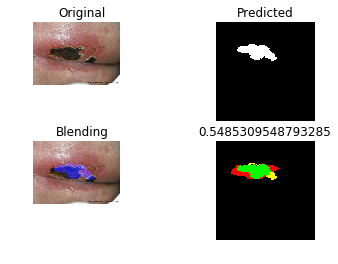

PREDICT... b_05
../testing_data/features/original/b_05.txt
sample => 1
 , IoU = 0.6434401053093463
Saving... ../training_data/model/original/results/model63.92/reports/b_05_report.png


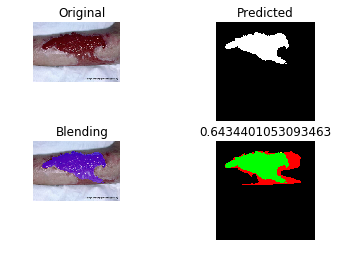

PREDICT... m_43
../testing_data/features/original/m_43.txt
sample => 1
 , IoU = 0.30360087960417814
Saving... ../training_data/model/original/results/model63.92/reports/m_43_report.png


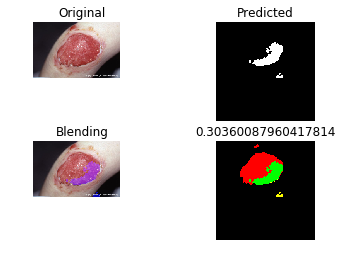

PREDICT... p1_73
../testing_data/features/original/p1_73.txt
sample => 1
 , IoU = 0.6723902752146353
Saving... ../training_data/model/original/results/model63.92/reports/p1_73_report.png


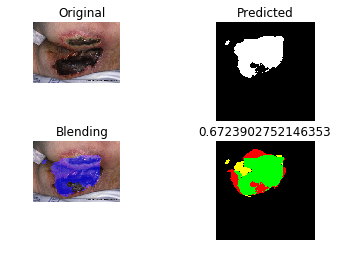

PREDICT... v1_84
../testing_data/features/original/v1_84.txt
sample => 1
 , IoU = 0.175662111033897
Saving... ../training_data/model/original/results/model63.92/reports/v1_84_report.png


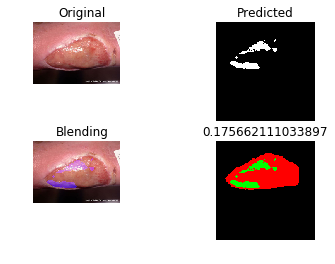

PREDICT... b_20
../testing_data/features/original/b_20.txt
sample => 1
 , IoU = 0.0
Saving... ../training_data/model/original/results/model63.92/reports/b_20_report.png


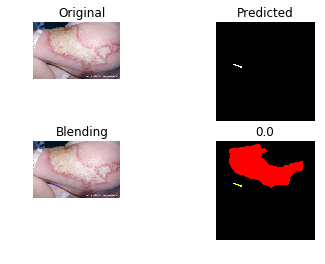

PREDICT... v1_32
../testing_data/features/original/v1_32.txt
sample => 1
 , IoU = 0.8902439024390244
Saving... ../training_data/model/original/results/model63.92/reports/v1_32_report.png


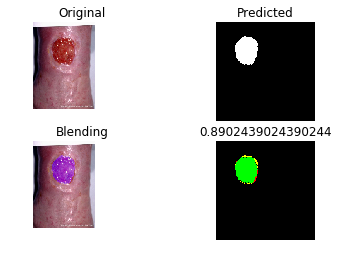

PREDICT... m_25
../testing_data/features/original/m_25.txt
sample => 1
 , IoU = 0.5326340326340326
Saving... ../training_data/model/original/results/model63.92/reports/m_25_report.png


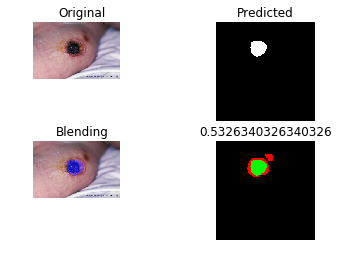

PREDICT... p1_81
../testing_data/features/original/p1_81.txt
sample => 1
 , IoU = 0.4101339545719278
Saving... ../training_data/model/original/results/model63.92/reports/p1_81_report.png


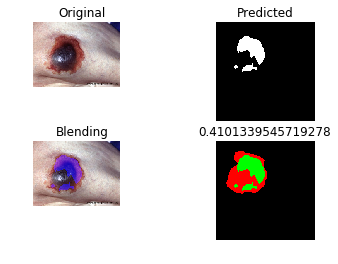

PREDICT... p1_72
../testing_data/features/original/p1_72.txt
sample => 1
 , IoU = 0.7664679159568427
Saving... ../training_data/model/original/results/model63.92/reports/p1_72_report.png


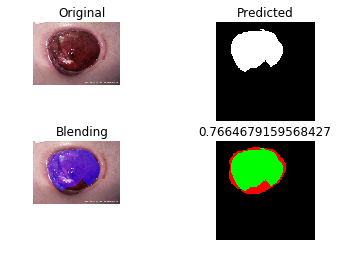

PREDICT... f_18
../testing_data/features/original/f_18.txt
sample => 1
 , IoU = 0.8599269183922046
Saving... ../training_data/model/original/results/model63.92/reports/f_18_report.png


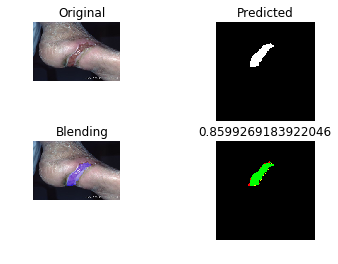

SEGMENTATION REPORT :: iou_avg 0.5799722586548901, iou_min 0.0
date: 2018-06-11 ,time: 13:16:38
	wound	not wound
    wound	90460	7606
not wound	72345	1599061
precision => 92.24
recall => 55.56
f-measure => 69.35
accuracy => 95.48
all sample => 1769472


In [32]:
#k-fold => 1
model_name = 'model63.92.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model49.98.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model47.32.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model52.18.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#winner
#k-fold => 5
model_name = 'model47.25.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

training 200 epoch 

In [ ]:
#k-fold => 1
model_name = 'model77.17.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model72.68.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model75.62.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model72.49.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model69.20.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 75 epoch

In [ ]:
#k-fold => 1
model_name = 'model65.78.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model66.88.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model64.01.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model67.26.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model63.80.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 300 epoch

In [ ]:
#k-fold => 1
model_name = 'model29.45.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model76.22.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model77.32.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model71.08.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model67.25.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 500 epoch

In [ ]:
#k-fold => 1
model_name = 'model81.56.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model75.72.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model79.10.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model74.85.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model73.01.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

CNN resize to 64 x 64

train 100 epochs

In [ ]:
#k-fold => 1
model_name = 'model65.17.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model65.84.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model68.46.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model63.42.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model64.31.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

test original augment

In [ ]:
type_folder = "original_augment/"

root_path = '../training_data/model/original/' 
color_dir_path = '../testing_data/features/' + type_folder
gray_dir_path = '../testing_data/images/gray/'

train 100 epoch

In [ ]:
#k-fold => 1
model_name = 'model69.40.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model69.15.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model71.23.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model66.72.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model67.08.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 200 epoch

In [ ]:
#k-fold => 1
model_name = 'model74.89.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model74.42.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model76.94.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model71.50.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model72.37.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 300 epoch

In [ ]:
#k-fold => 1
model_name = 'model75.12.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model76.60.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model79.53.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model74.17.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model75.00.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

train 500 epoch

In [ ]:
#k-fold => 1
model_name = 'model80.81.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 2
model_name = 'model78.93.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 3
model_name = 'model81.72.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 4
model_name = 'model76.54.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
#k-fold => 5
model_name = 'model76.54.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

original cnn resize to 64 x 64

In [ ]:
#k-fold => 5
model_name = 'model65.17.model'
segmentation(root_path, model_name, color_dir_path, gray_dir_path)

In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cv = cross_validation.KFold(len(a), n_folds=5, shuffle=False, random_state=None, )

In [ ]:
for train, test in cv :
    print([a[index] for index in train])
    print([a[index] for index in test])

In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
t = int(len(a) * 0.1)


aa = np.random.permutation(a)

In [ ]:
test_indices = aa[:t]
training_indices = aa[t:]

In [ ]:
print(aa[t:])
print(aa[:t])
print(os.system('clc'))


In [ ]:
print(test_indices)
print(training_indices)

In [ ]:
aa


In [ ]:
cv = cross_validation.KFold(180, n_folds=5, shuffle=False, random_state=None, )

In [ ]:
for train, test in cv :
    print(train)
    print(test)

In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
for number in (a+b):
    print(numbet)